In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('selected_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

SUBJECT_ID: Identificador do paciente
HADM_ID: identificador da internação 
ICD9-CODE: identificador da doença
A IDADE CORRESPONDE AO DOB - ADMITTIME

In [2]:
df.head(10)

,SUBJECT_ID,HADM_ID,ICD9_CODE,DOB,GENDER,ADMITTIME,DISCHTIME,INSURANCE,DIAGNOSIS
0,249,116935,49322,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
1,249,116935,51882,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
2,249,116935,41071,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
3,249,116935,42841,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
4,249,116935,99812,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
5,249,116935,5849,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
6,249,116935,42731,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
7,249,116935,4660,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
8,249,116935,4589,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS
9,249,116935,41401,2075-03-13 00:00:00,F,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,UNSTABLE ANGINA;ASTHMA;BRONCHITIS


In [3]:
#verifica se ADMITTIME e DISCHTIME estão no formato datetime
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
df['DOB'] = pd.to_datetime(df['DOB'])

In [4]:
# calcula a "idade" do paciente
df['DAYS_STAY'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.days
df['AGE'] = df['ADMITTIME'].dt.year - df['DOB'].dt.year

In [5]:
# # Cálculo de 'AVG_DAYS_STAY' para os dados de treinamento
# df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
# df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
# df['AVG_DAYS_STAY'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.days

# #Agrega por diagnostico e calcula a média
# df_new = df.groupby('DIAGNOSIS')['AVG_DAYS_STAY'].mean().reset_index()

# # Adiciona a coluna com o tempo médio de acordo com o diagnóstico
# df = pd.merge(df, df_new, on='DIAGNOSIS', how='left')
# df.head(5)

In [6]:
#remove as colunas que nao serão mais utilizadas
df = df.drop('ADMITTIME', axis=1)
df = df.drop('DISCHTIME', axis=1)
df = df.drop('DIAGNOSIS', axis=1)
df = df.drop('DOB', axis=1)

In [7]:
df.head(10)

,SUBJECT_ID,HADM_ID,ICD9_CODE,GENDER,INSURANCE,DAYS_STAY,AGE
0,249,116935,49322,F,Medicare,13,74
1,249,116935,51882,F,Medicare,13,74
2,249,116935,41071,F,Medicare,13,74
3,249,116935,42841,F,Medicare,13,74
4,249,116935,99812,F,Medicare,13,74
5,249,116935,5849,F,Medicare,13,74
6,249,116935,42731,F,Medicare,13,74
7,249,116935,4660,F,Medicare,13,74
8,249,116935,4589,F,Medicare,13,74
9,249,116935,41401,F,Medicare,13,74


In [8]:
#categorias segundo os 3 primeiros dígitos do código ICD-9
categories = {
    '001': 'Infectious and Parasitic Diseases',
    '140': 'Neoplasms',
    '240': 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders',
    '280': 'Diseases of the Blood and Blood-forming Organs',
    '290': 'Mental Disorders',
    '320': 'Diseases of the Nervous System and Sense Organs',
    '390': 'Diseases of the Circulatory System',
    '460': 'Diseases of the Respiratory System',
    '520': 'Diseases of the Digestive System',
    '580': 'Diseases of the Genitourinary System',
    '630': 'Complications of Pregnancy, Childbirth, and the Puerperium',
    '680': 'Diseases of the Skin and Subcutaneous Tissue',
    '710': 'Diseases of the Musculoskeletal System and Connective Tissue',
    '740': 'Congenital Anomalies',
    '760': 'Certain Conditions originating in the Perinatal Period',
    '780': 'Symptoms, Signs and Ill-defined Conditions',
    '800': 'Injury and Poisoning',
    'E80': 'Supplementary Classification of External Causes of Injury and Poisoning',
    'V01': 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services',
    'M80': 'Morphology of Neoplasms'
}

#converte e associa o diagnostico do paciente usando as categorias
def new_categories(code):
    if pd.isnull(code):  # Tratar valores nulos
        return 'N/A'
    elif isinstance(code, float):  # Tratar valores inválidos (float)
        return 'Invalid'
    else:
        digits = code[:3]
        if digits[0] == 'V':
            return categories['V01']
        if digits[0] == 'E':
            return categories['E80']
        if digits[0] == 'M':
            return categories['M80']
        if not digits[0] in ['0','1','2','3','4','5','6','7','8','9']:
            return 'Other'
        if int(digits) >= 800 and int(digits) <= 999:
            return categories['800']
        else:
            previous_key = None
            for key in categories:
                #print(code)
                if int(digits) < int(key):
                    if previous_key is not None:
                        return categories[previous_key]
                    return categories[key]
                previous_key = key
            return 'Other'
        
df['DIAGNOSIS_CATEGORY'] = df['ICD9_CODE'].apply(new_categories)

In [9]:
df.head(10)

,SUBJECT_ID,HADM_ID,ICD9_CODE,GENDER,INSURANCE,DAYS_STAY,AGE,DIAGNOSIS_CATEGORY
0,249,116935,49322,F,Medicare,13,74,Diseases of the Respiratory System
1,249,116935,51882,F,Medicare,13,74,Diseases of the Respiratory System
2,249,116935,41071,F,Medicare,13,74,Diseases of the Circulatory System
3,249,116935,42841,F,Medicare,13,74,Diseases of the Circulatory System
4,249,116935,99812,F,Medicare,13,74,Injury and Poisoning
5,249,116935,5849,F,Medicare,13,74,Diseases of the Genitourinary System
6,249,116935,42731,F,Medicare,13,74,Diseases of the Circulatory System
7,249,116935,4660,F,Medicare,13,74,Diseases of the Respiratory System
8,249,116935,4589,F,Medicare,13,74,Diseases of the Circulatory System
9,249,116935,41401,F,Medicare,13,74,Diseases of the Circulatory System


In [10]:
diagnosis_dummies = pd.get_dummies(df['DIAGNOSIS_CATEGORY'], prefix='Diagnosis')

# to concatenate the dummies back into the original DataFrame:
df = pd.concat([df, diagnosis_dummies], axis=1)
df = df.drop('DIAGNOSIS_CATEGORY', axis=1)

In [11]:
df.head(10)

,SUBJECT_ID,HADM_ID,ICD9_CODE,GENDER,INSURANCE,DAYS_STAY,AGE,Diagnosis_Certain Conditions originating in the Perinatal Period,"Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",Diagnosis_Congenital Anomalies,...,Diagnosis_Diseases of the Skin and Subcutaneous Tissue,"Diagnosis_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",Diagnosis_Infectious and Parasitic Diseases,Diagnosis_Injury and Poisoning,Diagnosis_Mental Disorders,Diagnosis_N/A,Diagnosis_Neoplasms,Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning,Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"Diagnosis_Symptoms, Signs and Ill-defined Conditions"
0,249,116935,49322,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,249,116935,51882,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,249,116935,41071,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,249,116935,42841,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,249,116935,99812,F,Medicare,13,74,False,False,False,...,False,False,False,True,False,False,False,False,False,False
5,249,116935,5849,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,249,116935,42731,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,249,116935,4660,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,249,116935,4589,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,249,116935,41401,F,Medicare,13,74,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
df.drop('ICD9_CODE', axis=1)

,SUBJECT_ID,HADM_ID,GENDER,INSURANCE,DAYS_STAY,AGE,Diagnosis_Certain Conditions originating in the Perinatal Period,"Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",Diagnosis_Congenital Anomalies,Diagnosis_Diseases of the Blood and Blood-forming Organs,...,Diagnosis_Diseases of the Skin and Subcutaneous Tissue,"Diagnosis_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",Diagnosis_Infectious and Parasitic Diseases,Diagnosis_Injury and Poisoning,Diagnosis_Mental Disorders,Diagnosis_N/A,Diagnosis_Neoplasms,Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning,Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"Diagnosis_Symptoms, Signs and Ill-defined Conditions"
0,249,116935,F,Medicare,13,74,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,249,116935,F,Medicare,13,74,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,249,116935,F,Medicare,13,74,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,249,116935,F,Medicare,13,74,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,249,116935,F,Medicare,13,74,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651042,44128,141304,M,Private,15,51,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
651043,44128,141304,M,Private,15,51,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
651044,44128,141304,M,Private,15,51,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
651045,44128,141304,M,Private,15,51,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
#cria um UNIQUE_ID para identificar o paciente e internação de forma única 
df['UNIQUE_ID'] = df['SUBJECT_ID'].astype(str) + '_' + df['HADM_ID'].astype(str)

In [14]:
df = df.drop('SUBJECT_ID', axis=1)
df = df.drop('HADM_ID', axis=1)

In [15]:
df.drop('ICD9_CODE', axis=1)

,GENDER,INSURANCE,DAYS_STAY,AGE,Diagnosis_Certain Conditions originating in the Perinatal Period,"Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",Diagnosis_Congenital Anomalies,Diagnosis_Diseases of the Blood and Blood-forming Organs,Diagnosis_Diseases of the Circulatory System,Diagnosis_Diseases of the Digestive System,...,"Diagnosis_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",Diagnosis_Infectious and Parasitic Diseases,Diagnosis_Injury and Poisoning,Diagnosis_Mental Disorders,Diagnosis_N/A,Diagnosis_Neoplasms,Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning,Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"Diagnosis_Symptoms, Signs and Ill-defined Conditions",UNIQUE_ID
0,F,Medicare,13,74,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,249_116935
1,F,Medicare,13,74,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,249_116935
2,F,Medicare,13,74,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,249_116935
3,F,Medicare,13,74,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,249_116935
4,F,Medicare,13,74,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,249_116935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651042,M,Private,15,51,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,44128_141304
651043,M,Private,15,51,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,44128_141304
651044,M,Private,15,51,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,44128_141304
651045,M,Private,15,51,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,44128_141304


In [16]:
df1 = df[['UNIQUE_ID', 'GENDER', 'INSURANCE', 'DAYS_STAY', 'AGE']]

df2 = df.drop(['GENDER', 'INSURANCE', 'DAYS_STAY', 'AGE', 'ICD9_CODE'], axis=1)

In [17]:
df2.head(5)

,Diagnosis_Certain Conditions originating in the Perinatal Period,"Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",Diagnosis_Congenital Anomalies,Diagnosis_Diseases of the Blood and Blood-forming Organs,Diagnosis_Diseases of the Circulatory System,Diagnosis_Diseases of the Digestive System,Diagnosis_Diseases of the Genitourinary System,Diagnosis_Diseases of the Musculoskeletal System and Connective Tissue,Diagnosis_Diseases of the Nervous System and Sense Organs,Diagnosis_Diseases of the Respiratory System,...,"Diagnosis_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",Diagnosis_Infectious and Parasitic Diseases,Diagnosis_Injury and Poisoning,Diagnosis_Mental Disorders,Diagnosis_N/A,Diagnosis_Neoplasms,Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning,Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"Diagnosis_Symptoms, Signs and Ill-defined Conditions",UNIQUE_ID
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,249_116935
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,249_116935
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,249_116935
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,249_116935
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,249_116935


In [18]:
df1

,UNIQUE_ID,GENDER,INSURANCE,DAYS_STAY,AGE
0,249_116935,F,Medicare,13,74
1,249_116935,F,Medicare,13,74
2,249_116935,F,Medicare,13,74
3,249_116935,F,Medicare,13,74
4,249_116935,F,Medicare,13,74
...,...,...,...,...,...
651042,44128_141304,M,Private,15,51
651043,44128_141304,M,Private,15,51
651044,44128_141304,M,Private,15,51
651045,44128_141304,M,Private,15,51


In [19]:
def sum_with_max_of_one(x):
    return min(1, x.sum())

df2 = df2.groupby('UNIQUE_ID').agg(sum_with_max_of_one).reset_index()
df1 = df1.groupby('UNIQUE_ID')
df1.head(10)

,UNIQUE_ID,GENDER,INSURANCE,DAYS_STAY,AGE
0,249_116935,F,Medicare,13,74
1,249_116935,F,Medicare,13,74
2,249_116935,F,Medicare,13,74
3,249_116935,F,Medicare,13,74
4,249_116935,F,Medicare,13,74
...,...,...,...,...,...
651029,44128_141304,M,Private,15,51
651030,44128_141304,M,Private,15,51
651031,44128_141304,M,Private,15,51
651032,44128_141304,M,Private,15,51


In [49]:
df1_new = df1.first().reset_index()
df2.head(10)

,UNIQUE_ID,Diagnosis_Certain Conditions originating in the Perinatal Period,"Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",Diagnosis_Congenital Anomalies,Diagnosis_Diseases of the Blood and Blood-forming Organs,Diagnosis_Diseases of the Circulatory System,Diagnosis_Diseases of the Digestive System,Diagnosis_Diseases of the Genitourinary System,Diagnosis_Diseases of the Musculoskeletal System and Connective Tissue,Diagnosis_Diseases of the Nervous System and Sense Organs,...,Diagnosis_Diseases of the Skin and Subcutaneous Tissue,"Diagnosis_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",Diagnosis_Infectious and Parasitic Diseases,Diagnosis_Injury and Poisoning,Diagnosis_Mental Disorders,Diagnosis_N/A,Diagnosis_Neoplasms,Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning,Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"Diagnosis_Symptoms, Signs and Ill-defined Conditions"
0,10000_187813,0,0,0,1,1,1,1,1,0,...,0,1,1,1,1,0,0,0,0,1
1,10001_118420,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,10002_132138,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,10003_144039,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,10004_161106,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,1,1,0
5,10004_164713,0,0,0,0,1,1,1,0,1,...,0,1,0,1,0,0,0,1,1,1
6,10005_181146,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,10006_142345,0,0,0,1,1,1,0,0,0,...,0,1,1,1,1,0,0,1,1,1
8,10007_166331,0,0,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
9,10008_180596,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [50]:
df1_new.head(10)

,UNIQUE_ID,GENDER,INSURANCE,DAYS_STAY,AGE
0,10000_187813,M,Self Pay,20,50
1,10001_118420,M,Government,1,0
2,10002_132138,M,Private,2,0
3,10003_144039,M,Private,10,41
4,10004_161106,M,Medicare,3,53
5,10004_164713,M,Medicare,17,52
6,10005_181146,F,Medicaid,2,0
7,10006_142345,F,Medicare,8,70
8,10007_166331,F,Private,8,55
9,10008_180596,F,Private,34,0


In [51]:
df_merged = pd.merge(df1_new, df2, on='UNIQUE_ID')

In [52]:
insurance_dummies = pd.get_dummies(df_merged['INSURANCE'], prefix='Insurance')

# to concatenate these new columns back into the original DataFrame, you would do:
df_merged = pd.concat([df_merged, insurance_dummies], axis=1)
df_merged = df_merged.drop('INSURANCE', axis=1)
df_merged.head(5)

,UNIQUE_ID,GENDER,DAYS_STAY,AGE,Diagnosis_Certain Conditions originating in the Perinatal Period,"Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",Diagnosis_Congenital Anomalies,Diagnosis_Diseases of the Blood and Blood-forming Organs,Diagnosis_Diseases of the Circulatory System,Diagnosis_Diseases of the Digestive System,...,Diagnosis_N/A,Diagnosis_Neoplasms,Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning,Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"Diagnosis_Symptoms, Signs and Ill-defined Conditions",Insurance_Government,Insurance_Medicaid,Insurance_Medicare,Insurance_Private,Insurance_Self Pay
0,10000_187813,M,20,50,0,0,0,1,1,1,...,0,0,0,0,1,False,False,False,False,True
1,10001_118420,M,1,0,0,0,0,0,0,0,...,0,0,0,1,0,True,False,False,False,False
2,10002_132138,M,2,0,1,0,0,0,0,0,...,0,0,0,1,0,False,False,False,True,False
3,10003_144039,M,10,41,0,0,0,1,1,0,...,0,0,1,0,0,False,False,False,True,False
4,10004_161106,M,3,53,0,0,0,0,1,0,...,0,0,1,1,0,False,False,True,False,False


In [53]:
insurances = ['Insurance_Government', 'Insurance_Medicaid', 'Insurance_Medicare', 'Insurance_Private', 'Insurance_Self Pay']  

for col in insurances:
    df_merged[col] = df_merged[col].astype(int)

df_merged.head(1)

,UNIQUE_ID,GENDER,DAYS_STAY,AGE,Diagnosis_Certain Conditions originating in the Perinatal Period,"Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",Diagnosis_Congenital Anomalies,Diagnosis_Diseases of the Blood and Blood-forming Organs,Diagnosis_Diseases of the Circulatory System,Diagnosis_Diseases of the Digestive System,...,Diagnosis_N/A,Diagnosis_Neoplasms,Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning,Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"Diagnosis_Symptoms, Signs and Ill-defined Conditions",Insurance_Government,Insurance_Medicaid,Insurance_Medicare,Insurance_Private,Insurance_Self Pay
0,10000_187813,M,20,50,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1


In [54]:
df_merged['GENDER'] = df_merged['GENDER'].replace({'F': 1, 'M': 0})

In [55]:
df_no_duplicates = df_merged.drop_duplicates()

In [56]:
df_no_duplicates

,UNIQUE_ID,GENDER,DAYS_STAY,AGE,Diagnosis_Certain Conditions originating in the Perinatal Period,"Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",Diagnosis_Congenital Anomalies,Diagnosis_Diseases of the Blood and Blood-forming Organs,Diagnosis_Diseases of the Circulatory System,Diagnosis_Diseases of the Digestive System,...,Diagnosis_N/A,Diagnosis_Neoplasms,Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning,Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"Diagnosis_Symptoms, Signs and Ill-defined Conditions",Insurance_Government,Insurance_Medicaid,Insurance_Medicare,Insurance_Private,Insurance_Self Pay
0,10000_187813,0,20,50,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1
1,10001_118420,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,10002_132138,0,2,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,10003_144039,0,10,41,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
4,10004_161106,0,3,53,0,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,99999_113369,1,5,63,0,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
58972,9999_117856,0,1,43,0,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
58973,999_173415,0,10,70,0,0,0,0,1,0,...,0,1,1,1,1,0,0,1,0,0
58974,99_187373,0,5,73,0,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0


In [57]:
df_no_duplicates = df_no_duplicates.drop('Diagnosis_N/A', axis=1)

In [58]:
diagnosis_cols = ['Diagnosis_Certain Conditions originating in the Perinatal Period', 
                  'Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium',
                  'Diagnosis_Congenital Anomalies',
                  'Diagnosis_Diseases of the Blood and Blood-forming Organs',
                  'Diagnosis_Diseases of the Circulatory System',
                  'Diagnosis_Diseases of the Digestive System',
                  'Diagnosis_Diseases of the Genitourinary System',
                  'Diagnosis_Diseases of the Musculoskeletal System and Connective Tissue',
                  'Diagnosis_Diseases of the Nervous System and Sense Organs',
                  'Diagnosis_Diseases of the Respiratory System',
                  'Diagnosis_Diseases of the Skin and Subcutaneous Tissue',
                  'Diagnosis_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders',
                  'Diagnosis_Infectious and Parasitic Diseases',
                  'Diagnosis_Injury and Poisoning',
                  'Diagnosis_Mental Disorders',
                  'Diagnosis_Neoplasms',
                  'Diagnosis_Supplementary Classification of External Causes of Injury and Poisoning',
                  'Diagnosis_Supplementary Classification of Factors influencing Health Status and Contact with Health Services',
                  'Diagnosis_Symptoms, Signs and Ill-defined Conditions']

# Para cada coluna de diagnóstico, agrupe por diagnóstico e calcule a média de `DAYS_STAY`
# essa parte do código serve apenas como auxílio para validar os resultados obtidos na sequência 
for col in diagnosis_cols:
    avg_days_stay = df_no_duplicates[df_no_duplicates[col]==1]['DAYS_STAY'].mean()
    print(f"Média de dias de estadia pra {col}: {avg_days_stay}")


# Para cada linha do dataframe, averigue os diagnósticos marcados com 1 e calcule a média de 'DAYS_STAY' para esses diagnósticos
# avg_days = []
# for idx, row in df_no_duplicates.iterrows():
#     avg_days_row = np.nanmean([df_no_duplicates[df_no_duplicates[col] == 1]['DAYS_STAY'].mean() * row[col] for col in diagnosis_cols if row[col] == 1])
#     if np.isnan(avg_days_row):
#         avg_days.append(0)  #se esse caso ocorrer é porque o paciente foi internado sem um diagnóstico específico
#     else:
#         avg_days.append(round(avg_days_row))


#pega a maior das médias
avg_days = []
for idx, row in df_no_duplicates.iterrows():
    means = [df_no_duplicates[df_no_duplicates[col] == 1]['DAYS_STAY'].mean() * row[col] for col in diagnosis_cols if row[col] == 1]
    if len(means) == 0:
        avg_days.append(0)  # se essa lista estiver vazia, o paciente foi internado sem um diagnóstico específico
    else:
        avg_days_row = np.nanmax(means)  # só calculamos o máximo se a lista não estiver vazia
        avg_days.append(round(avg_days_row))

# Adicione a lista `avg_days` como uma nova coluna no dataframe
df_no_duplicates['avg_days'] = avg_days

Média de dias de estadia pra Diagnosis_Certain Conditions originating in the Perinatal Period: 15.303024781341108
Média de dias de estadia pra Diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium: 10.16969696969697
Média de dias de estadia pra Diagnosis_Congenital Anomalies: 16.78845553822153
Média de dias de estadia pra Diagnosis_Diseases of the Blood and Blood-forming Organs: 11.456005370236497
Média de dias de estadia pra Diagnosis_Diseases of the Circulatory System: 9.708558030480656
Média de dias de estadia pra Diagnosis_Diseases of the Digestive System: 11.686863398381723
Média de dias de estadia pra Diagnosis_Diseases of the Genitourinary System: 11.601864181091878
Média de dias de estadia pra Diagnosis_Diseases of the Musculoskeletal System and Connective Tissue: 10.217149109718491
Média de dias de estadia pra Diagnosis_Diseases of the Nervous System and Sense Organs: 11.269901440485215
Média de dias de estadia pra Diagnosis_Diseases of the Respiratory System: 1

In [59]:
for col in ['AGE', 'DAYS_STAY']:
    Q1_train = df_no_duplicates[col].quantile(0.25)
    Q3_train = df_no_duplicates[col].quantile(0.75)
    IQR_train = Q3_train - Q1_train
    df_no_duplicates[col] = np.where((df_no_duplicates[col] > (Q3_train + 1.5*IQR_train)), (Q3_train + 1.5*IQR_train), df_no_duplicates[col])

Text(0, 0.5, 'Média de Dias de Internação')

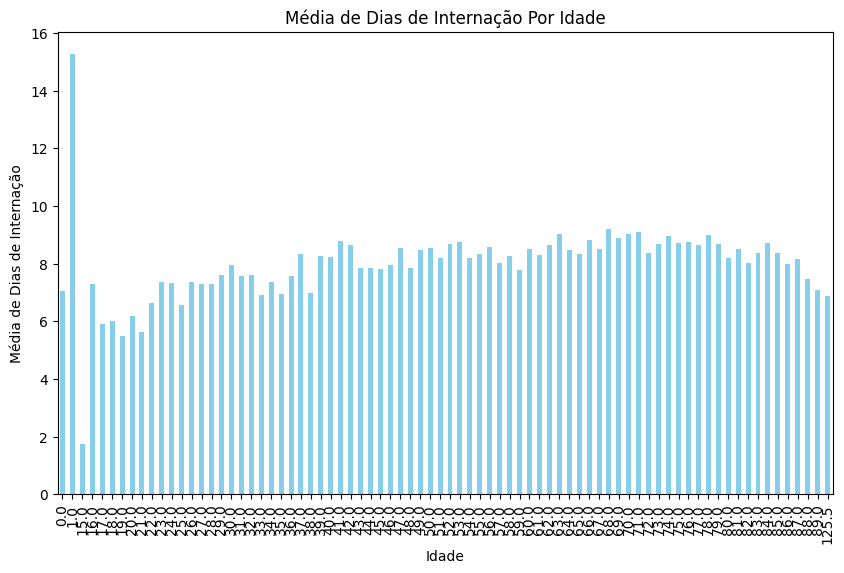

In [60]:
threshold = 18

df_new = df_no_duplicates.loc[df['AGE'] >= threshold]

age_stay_avg = df_new.groupby('AGE')['DAYS_STAY'].mean()

# Criar o plot
plt.figure(figsize=(10, 6))
age_stay_avg.plot(kind='bar', color='skyblue')

# Adicionar títulos e rótulos
plt.title('Média de Dias de Internação Por Idade')
plt.xlabel('Idade')
plt.ylabel('Média de Dias de Internação')

In [61]:
df_new.to_csv('processed_dataset.csv', index=False)